<a href="https://colab.research.google.com/github/mlabonne/linear-programming-course/blob/main/4_Maximize_Your_Marketing_ROI_with_Nonlinear_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Art of Spending: Optimizing Your Marketing Budget with Nonlinear Optimization
> Chapter 4 of the [Linear Programming Course](https://github.com/mlabonne/linear-programming-course)

❤️ Created by [@maximelabonne](https://twitter.com/maximelabonne).

Companion notebook to execute the code from the following article: 

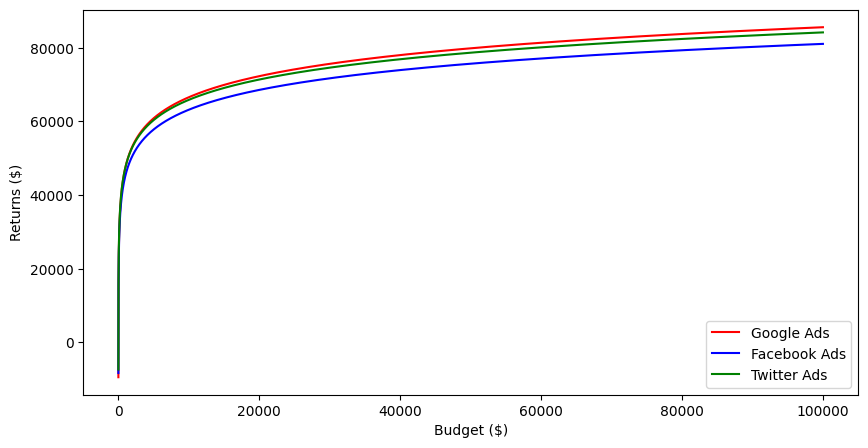

In [1]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)

TOTAL_BUDGET = 100_000

# Alpha and beta constants
alphas = np.array([-9453.72, -8312.84, -7371.33])
betas = np.array([8256.21, 7764.20, 7953.36])

# Linearly spaced numbers
x = np.linspace(1, TOTAL_BUDGET, TOTAL_BUDGET)

# Plot the response curves
fig = plt.figure(figsize=(10, 5), dpi=100)
plt.plot(x, alphas[0] + betas[0] * np.log(x), color='red', label='Google Ads')
plt.plot(x, alphas[1] + betas[1] * np.log(x), color='blue', label='Facebook Ads')
plt.plot(x, alphas[2] + betas[2] * np.log(x), color='green', label='Twitter Ads')
plt.xlabel('Budget ($)')
plt.ylabel('Returns ($)') 
plt.legend()
plt.show()

## Greedy algorithm

In [2]:
def greedy_optimization(TOTAL_BUDGET, alphas, betas, num_iterations=1_000):
    # Initialize the budget allocation and the best objective value
    google_budget = facebook_budget = twitter_budget = TOTAL_BUDGET / 3
    obj = alphas[0] + betas[0] * np.log(google_budget) + alphas[1] + betas[1] * np.log(facebook_budget) + alphas[2] + betas[2] * np.log(twitter_budget)

    for _ in range(num_iterations):
        # Generate a new random allocation
        random_allocation = np.random.dirichlet(np.ones(3)) * TOTAL_BUDGET
        google_budget_new, facebook_budget_new, twitter_budget_new = random_allocation

        # Calculate the new objective value
        new_obj = alphas[0] + betas[0] * np.log(google_budget_new) + alphas[1] + betas[1] * np.log(facebook_budget_new) + alphas[2] + betas[2] * np.log(twitter_budget_new)

        # If the new allocation improves the objective value, keep it
        if new_obj > obj:
            google_budget, facebook_budget, twitter_budget = google_budget_new, facebook_budget_new, twitter_budget_new
            obj = new_obj

    # Return the best allocation and the corresponding objective value
    return (google_budget, facebook_budget, twitter_budget), obj

In [3]:
%%time

# Run the greedy optimization
(best_google, best_facebook, best_twitter), obj = greedy_optimization(TOTAL_BUDGET, alphas, betas)

# Print the result
print('='*59 + '\n' + ' '*24 + 'Solution' + ' '*24 + '\n' + '='*59)
print(f'Returns = ${round(obj):,}\n')
print('Marketing allocation:')
print(f' - Google Ads   = ${round(best_google):,}')
print(f' - Facebook Ads = ${round(best_facebook):,}')
print(f' - Twitter Ads  = ${round(best_twitter):,}')

                        Solution                        
Returns = $224,534

Marketing allocation:
 - Google Ads   = $35,476
 - Facebook Ads = $31,722
 - Twitter Ads  = $32,802
CPU times: user 39.8 ms, sys: 0 ns, total: 39.8 ms
Wall time: 40.7 ms


## Nonlinear optimization

In [4]:
import cvxpy as cp

# Variables
google   = cp.Variable(pos=True)
facebook = cp.Variable(pos=True)
twitter  = cp.Variable(pos=True)

# Constraint
constraint = [google + facebook + twitter <= TOTAL_BUDGET]

# Objective
obj = cp.Maximize(alphas[0] + betas[0] * cp.log(google)
                + alphas[1] + betas[1] * cp.log(facebook)
                + alphas[2] + betas[2] * cp.log(twitter))

In [5]:
%%time

# Solve
prob = cp.Problem(obj, constraint)
prob.solve(solver='ECOS', verbose=False)

# Print solution
print('='*59 + '\n' + ' '*24 + 'Solution' + ' '*24 + '\n' + '='*59)
print(f'Status = {prob.status}')
print(f'Returns = ${round(prob.value):,}\n')
print('Marketing allocation:')
print(f' - Google Ads   = ${round(google.value):,}')
print(f' - Facebook Ads = ${round(facebook.value):,}')
print(f' - Twitter Ads  = ${round(twitter.value):,}')

                        Solution                        
Status = optimal
Returns = $224,540

Marketing allocation:
 - Google Ads   = $34,439
 - Facebook Ads = $32,386
 - Twitter Ads  = $33,175
CPU times: user 28.6 ms, sys: 31 µs, total: 28.7 ms
Wall time: 56 ms


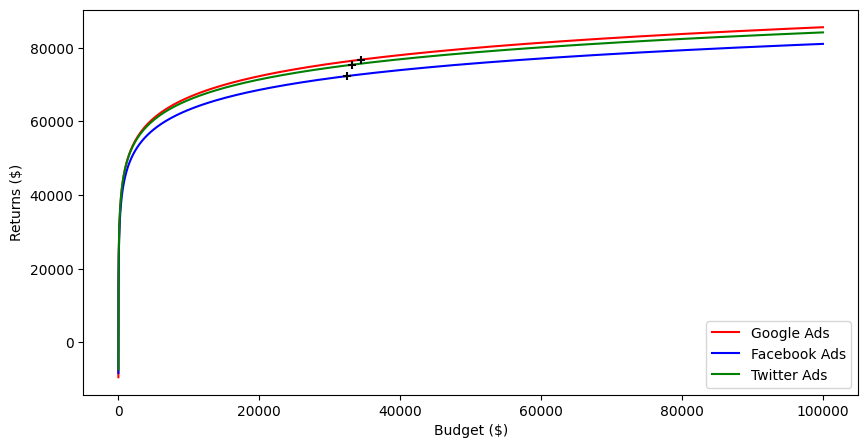

In [6]:
# Plot the functions and the results
fig = plt.figure(figsize=(10, 5), dpi=100)

plt.plot(x, alphas[0] + betas[0] * np.log(x), color='red', label='Google Ads')
plt.plot(x, alphas[1] + betas[1] * np.log(x), color='blue', label='Facebook Ads')
plt.plot(x, alphas[2] + betas[2] * np.log(x), color='green', label='Twitter Ads')

# Plot optimal points
plt.scatter([google.value, facebook.value, twitter.value],
            [alphas[0] + betas[0] * np.log(google.value),
             alphas[1] + betas[1] * np.log(facebook.value),
             alphas[2] + betas[2] * np.log(twitter.value)],
            marker="+", color='black', zorder=10)

plt.xlabel('Budget ($)')
plt.ylabel('Returns ($)') 
plt.legend()
plt.show()

## Comparison

In [7]:
%%time

# List to store the best objective value for each number of iterations
best_obj_list = []

# Range of number of iterations to test
num_iterations_range = np.logspace(0, 6, 20).astype(int)

# Run the greedy algorithm for each number of iterations and store the best objective value
for num_iterations in num_iterations_range:
    _, best_obj = greedy_optimization(TOTAL_BUDGET, alphas, betas, num_iterations)
    best_obj_list.append(best_obj)

CPU times: user 1min, sys: 2.37 s, total: 1min 2s
Wall time: 1min 14s


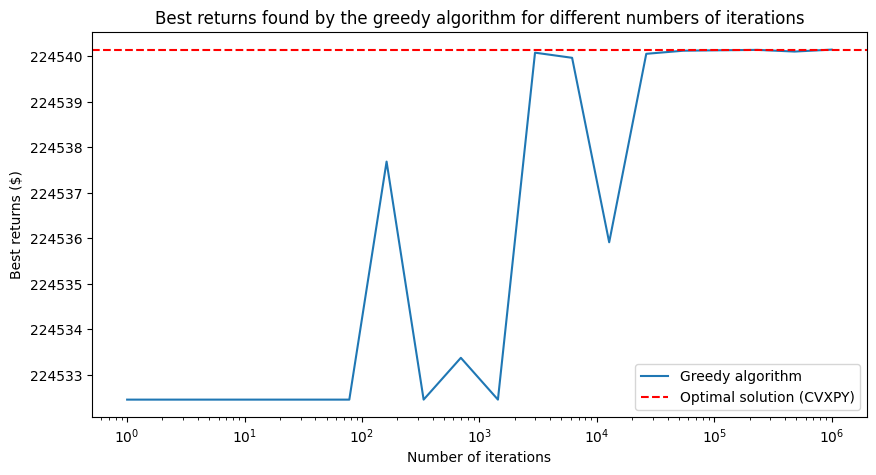

In [8]:
# Plot the results
plt.figure(figsize=(10, 5), dpi=100)
plt.ticklabel_format(useOffset=False)
plt.plot(num_iterations_range, best_obj_list, label='Greedy algorithm')
plt.axhline(y=prob.value, color='r', linestyle='--', label='Optimal solution (CVXPY)')
plt.xlabel('Number of iterations')
plt.xticks(num_iterations_range)
plt.xscale("log")
plt.ylabel('Best returns ($)')
plt.title('Best returns found by the greedy algorithm for different numbers of iterations')
plt.legend()
plt.show()